In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import disk
%matplotlib inline

In [2]:
def adaptive_thresh(input_img):

    h, w = input_img.shape

    S = int(w/8)
    s2 = int(S/2)
    T = 15.0

    #integral img
    int_img = np.zeros_like(input_img, dtype=np.uint32)
    for col in range(w):
        for row in range(h):
            int_img[row,col] = input_img[0:row,0:col].sum()

    #output img
    out_img = np.zeros_like(input_img)    

    for col in range(w):
        for row in range(h):
            #SxS region
            y0 = max(row-s2, 0)
            y1 = min(row+s2, h-1)
            x0 = max(col-s2, 0)
            x1 = min(col+s2, w-1)

            count = (y1-y0)*(x1-x0)
            #print(x0,y0,x1,y1)
            sum_ = int_img[y1, x1]-int_img[y0, x1]-int_img[y1, x0]+int_img[y0, x0]

            if input_img[row, col]*count < sum_*(100.-T)/100.:
                out_img[row,col] = 0
            else:
                out_img[row,col] = 255

    return out_img


def faster_bradley_threshold(image, threshold=70, window_r=45):
    percentage = threshold / 100.
    window_diam = 2*window_r + 1
    # convert image to numpy array of grayscale values
    img = np.array(image).astype(np.float) # float for mean precision 
    # matrix of local means with scipy
    means = ndimage.uniform_filter(img, window_diam)
    # result: 0 for entry less than percentage*mean, 255 otherwise 
    height, width = img.shape[:2]
    result = np.zeros((height,width), np.uint8)   # initially all 0
    result[img >= percentage * means] = 255 
    return np.array(result)


In [17]:
def get_shading(rim,mask):
    im=rim

    im=cv2.copyMakeBorder(rim, top=100, bottom=100, left=100, right=100, borderType= cv2.BORDER_CONSTANT, value=255)
    mask=cv2.copyMakeBorder(mask, top=100, bottom=100, left=100, right=100, borderType= cv2.BORDER_CONSTANT, value=255)
    mask=mask/255
    shading=np.zeros(im.shape)
    for i in range(len(im)):
        #print(i)
        for j in range(len(im[i])):
            if mask[i][j]>0:
                shading[i][j]=im[i][j]
            else:
                dx=3
                dy=3
                while np.count_nonzero(mask[i-dx:i+dx,j-dy:j+dy])<25:
                    dx+=2
                    dy+=1
                curr=0.0
                tot=0.0
                for it1 in range(max(i-dx,0),min(i+dx,len(mask))):
                    for it2 in range(max(j-dy,0),min(j+dy,len(mask[0]))):
                        if mask[it1][it2]>0:
                            curr+=im[it1][it2]
                            tot+=1
                shading[i][j]=curr/tot



    return shading[100:-100,100:-100]



def get_reflectance(im,shading):
    reflectance=np.zeros(im.shape,dtype='float64')
    for i in range(len(im)):
        for j in range(len(im[i])):
            if shading[i][j]==0:
                reflectance[i][j]=im[i][j]
            else:
                reflectance[i][j]=((im[i][j]*1.0)/shading[i][j])
        

    return reflectance

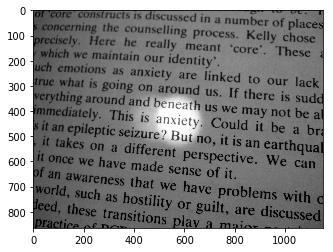

In [36]:
rim=cv2.imread('./ACCV-Dataset/RealWorld/012.png',0)
plt.imshow(rim,cmap='gray')

/home/shyamgopal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in uint_scalars


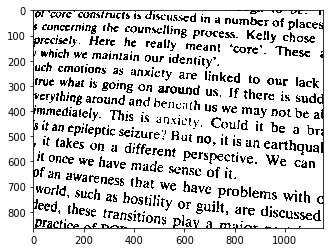

In [46]:
rim=cv2.imread('./ACCV-Dataset/RealWorld/012.png',0)
mask=adaptive_thresh(rim)
c=0
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if mask[i][j]>0:
            mask[i][j]=255
        else:
            mask[i][j]=0
            c+=1
plt.imshow(mask,cmap='gray',vmax=255,vmin=0)



In [47]:
shading=get_shading(rim,mask)

50.0 255.0
0 255


(-0.5, 1151.5, 863.5, -0.5)

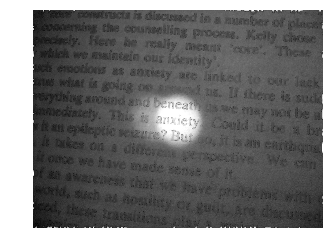

In [48]:
plt.imshow(shading,cmap='gray')
print(np.min(shading),np.max(shading))

rim=cv2.imread('./ACCV-Dataset/RealWorld/012.png',0)
print(np.min(rim),np.max(rim))
plt.axis('off')

0.0 1.0


(-0.5, 1151.5, 863.5, -0.5)

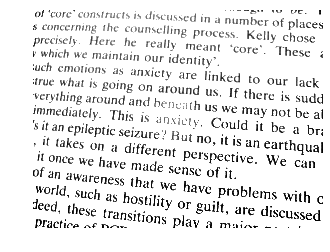

In [49]:
nshading = (255*(shading-np.min(shading)))/(np.max(shading)-np.min(shading))
rim=get_reflectance(rim,shading)
print(np.min(rim),np.max(rim))
plt.imshow(rim,cmap='gray')
plt.axis('off')

In [50]:

#rim=cv2.resize(rim,None,fx=0.2,fy=0.2)
rim=rim*255.0
for i in range(2):
    
    print("Iteration",i)
    #mask=cv2.adaptiveThreshold(rim, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,41,20) 
    mask=adaptive_thresh(rim)

    #mask=cv2.dilate(mask,circle,iterations = 1)
    print("Thresholding done")
    n3=str(i)+'mask.png'
    #cv2.imwrite(n3,mask)

    shading=get_shading(rim,mask)
    print("shading done")
    
    #plt.imshow(shading,cmap='gray')

    rim=get_reflectance(rim,shading)
    ms=np.max(rim)
    mi=np.min(rim)
    rim=255*(rim-np.min(rim))
    rim=rim/(ms-mi)
    n1=str(i)+'shading.png'
    n2=str(i)+'reflectance.png'
    #cv2.imwrite(n1,shading)
    #cv2.imwrite(n2,rim)

Iteration 0


/home/shyamgopal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in uint_scalars


Thresholding done
shading done
Iteration 1
Thresholding done
shading done


True

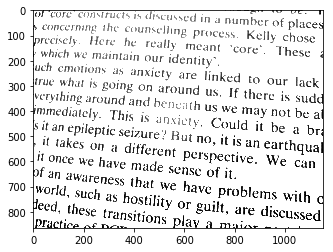

In [57]:
plt.imshow(rim,cmap='gray')
cv2.imwrite('ref.png',rim)

169 255
(864, 1152)


/home/shyamgopal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  if sys.path[0] == '':


0.5478323522129728


(-0.5, 1151.5, 863.5, -0.5)

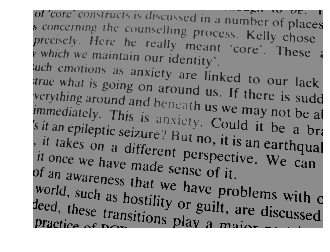

In [60]:
print(np.min(shading),np.max(shading))
print(shading.shape)
shading=np.array(shading,dtype='uint8')
ret,shadow_mask = cv2.threshold(shading,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

im1=cv2.imread('./ACCV-Dataset/RealWorld/012.png',0)
gm=0
num=0.0
dem=0.0
for i in range(len(im1)):
    for j in range(len(im1[i])):
        num+=im1[i][j]*shadow_mask[i][j]*mask[i][j]
        dem+=mask[i][j]*shadow_mask[i][j]

gm=num/dem
print(gm)
rim=cv2.imread('ref.png',0)
fin=np.zeros(im1.shape,dtype='float64')
for i in range(len(fin)):
    for j in range(len(fin[i])):
        fin[i][j]=rim[i][j]*gm
plt.imshow(fin,cmap='gray',vmax=255,vmin=0)
plt.axis('off')